# Comparing IPCA Methods: Alternating Least Squares vs Pymanopt

This notebook compares two methods for computing IPCA (Instrumented Principal Component Analysis) factors:

1. **Alternating Least Squares (ALS)** - Original implementation from Kelly-Pruitt-Su (2019)
2. **Pymanopt/Stiefel** - Riemannian optimization on the Stiefel manifold

We will:
- Generate BGN panel data and calculate moments
- Test different initialization strategies
- Compare convergence speed and final objective values
- Analyze the correlation between factors from both methods

## IPCA Objective Function

Both methods minimize the sum of squared pricing errors:

$$\min_{\Gamma, f} \text{RSS}(\Gamma, f) = \sum_t \sum_i (r_{it} - Z_{it}' \Gamma f_t)^2$$

Subject to: $\Gamma' \Gamma = I_K$ (orthonormality constraint)

Using sufficient statistics:

$$\text{RSS}(\Gamma) = \sum_t \left( r_t' r_t - x_t' \Gamma (\Gamma' W_t \Gamma)^{-1} \Gamma' x_t \right)$$

where $W_t = Z_t' Z_t$ and $x_t = Z_t' r_t$

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import subprocess
import sys
from scipy import linalg
from scipy.linalg import qr
import time
import os

# Set random seed for reproducibility
np.random.seed(42)

# Add paths for imports
sys.path.insert(0, 'tests/original_code')
sys.path.insert(0, '.')

print("Imports successful")

Imports successful


## 1. Generate Panel Data and Calculate Moments

In [62]:
# Generate BGN panel data
print("Generating BGN panel data...")
result = subprocess.run(
    ['python', 'generate_panel.py', 'bgn', '0'],
    capture_output=True,
    text=True
)

if result.returncode != 0:
    print("STDERR:", result.stderr)
    raise RuntimeError(f"Panel generation failed: {result.stderr}")
    
print(result.stdout)

Generating BGN panel data...
PANEL GENERATION
Model: BGN
Identifier: 0
Started at Wed 31 Dec 2025, 10:04AM
started import of vasicek at Wed 31 Dec 2025, 10:04AM
finished import of vasicek at Wed 31 Dec 2025, 10:04AM

Parameters:
  N (firms): 1000
  T (periods): 400
  Burnin: 300
  Characteristics: ['size', 'bm', 'agr', 'roe', 'mom']

----------------------------------------------------------------------
Generating panel for BGN model...
----------------------------------------------------------------------
Creating arrays...
Creating panel...

Firm-months with bm=0 (after burnin): 2,710

----------------------------------------------------------------------
Saving panel and arrays to c:\Users\kerry\repos\CodeNew\NoIPCA\outputs\bgn_0_panel.pkl...
----------------------------------------------------------------------
[OK] Saved successfully

----------------------------------------------------------------------
PANEL SUMMARY
---------------------------------------------------------------

In [63]:
# Calculate moments
print("Calculating moments...")
result = subprocess.run(
    ['python', 'calculate_moments.py', 'bgn_0'],
    capture_output=True,
    text=True
)

if result.returncode != 0:
    print("STDERR:", result.stderr)
    raise RuntimeError(f"Moments calculation failed: {result.stderr}")
    
print(result.stdout)

Calculating moments...
SDF CONDITIONAL MOMENTS CALCULATION
Panel ID: bgn_0
Model: bgn
Started at Wed 31 Dec 2025, 10:07AM

Loading panel from c:\Users\kerry\repos\CodeNew\NoIPCA\outputs\bgn_0_panel.pkl...
Loaded arrays: N=1000, T=400
started import of vasicek at Wed 31 Dec 2025, 10:07AM
finished import of vasicek at Wed 31 Dec 2025, 10:07AM

----------------------------------------------------------------------
Computing SDF conditional moments...
----------------------------------------------------------------------
Computing moments for months 660 to 699
  Total: 40 months
  Using parallel processing with n_jobs=10
  Processing in 1 chunks of 100 months each
----------------------------------------------------------------------

Chunk 1/1: months 660 to 699 (40 months)
  [OK] Chunk 1 saved to bgn_0_moments_chunk0.pkl

----------------------------------------------------------------------
[OK] All chunks computed in 43.5s (0.7 minutes)

------------------------------------------------

In [64]:
# Load panel and moments
with open('outputs/bgn_0_panel.pkl', 'rb') as f:
    panel_data = pickle.load(f)

with open('outputs/bgn_0_moments.pkl', 'rb') as f:
    moments_data = pickle.load(f)

# Extract panel DataFrame from dictionary
panel = panel_data['panel']

print(f"Panel shape: {panel.shape}")
print(f"Panel columns: {list(panel.columns)}")
print(f"\nMoments available for months: {min(moments_data['moments'].keys())} to {max(moments_data['moments'].keys())}")
print(f"Number of periods with moments: {len(moments_data['moments'])}")

Panel shape: (400000, 14)
Panel columns: ['month', 'firmid', 'mve', 'xret', 'A_1_taylor', 'A_2_taylor', 'A_1_proj', 'A_2_proj', 'roe', 'bm', 'mom', 'agr', 'rf_stand', 'size']

Moments available for months: 660 to 699
Number of periods with moments: 40


## 2. Prepare Data for IPCA

We'll focus on a single 360-month window for detailed comparison:
- Estimation window: months 300-659
- Out-of-sample: month 660

In [65]:
from config import CHARS_DEFAULT, N, BGN_BURNIN
import sys
sys.path.insert(0, 'tests/original_code')
import dkkm_functions as dkkm

# Parameters
K = 3  # Number of latent factors
chars = CHARS_DEFAULT  # ['size', 'bm', 'agr', 'roe', 'mom']
start = 300  # Start month (after burnin)
window_size = 360

# Prepare panel with rank-standardized characteristics
panel_ranked = panel.groupby('month')[chars].apply(
    lambda g: dkkm.rank_standardize(g)
).reset_index(level=0, drop=True)
panel_ranked['ones'] = 1  # Add intercept
panel_ranked['xret'] = panel['xret']  # Add returns

# Set multi-index for easier slicing
panel_ranked = panel_ranked.set_index([panel['month'], panel['firmid']])
panel_ranked.index.names = ['month', 'firmid']

print(f"Prepared panel for IPCA with K={K} factors")
print(f"Characteristics: {chars}")
print(f"Panel shape: {panel_ranked.shape}")

Prepared panel for IPCA with K=3 factors
Characteristics: ['size', 'bm', 'agr', 'roe', 'mom']
Panel shape: (400000, 7)


## 3. Define Objective Function

We'll compute the RSS objective function to evaluate both methods

In [66]:
def compute_rss(panel, Gamma, start_month, end_month, chars):
    """
    Compute the RSS objective function for IPCA.
    
    RSS(Gamma) = sum_t (r_t'r_t - x_t' Gamma (Gamma'W_t Gamma)^-1 Gamma'x_t)
    
    Parameters
    ----------
    panel : pd.DataFrame
        Panel with multi-index (month, firmid)
    Gamma : np.ndarray
        (L x K) loading matrix
    start_month : int
        First month in window
    end_month : int
        Last month in window (inclusive)
    chars : list
        List of characteristic names (including 'ones')
    
    Returns
    -------
    rss : float
        Residual sum of squares
    """
    L, K = Gamma.shape
    rss = 0.0
    chars_with_ones = chars + ['ones']
    
    for t in range(start_month, end_month + 1):
        # Extract data for this month
        panel_t = panel.loc[t]
        Z_t = panel_t[chars_with_ones].values  # (N x L)
        r_t = panel_t['xret'].values  # (N,)
        
        # Compute sufficient statistics
        W_t = Z_t.T @ Z_t  # (L x L)
        x_t = Z_t.T @ r_t  # (L,)
        
        # Compute r_t'r_t
        rtr = r_t @ r_t
        
        # Compute x_t' Gamma (Gamma'W_t Gamma)^-1 Gamma'x_t
        GtWG = Gamma.T @ W_t @ Gamma  # (K x K)
        Gtx = Gamma.T @ x_t  # (K,)
        
        # Solve (Gamma'W_t Gamma) gamma = Gamma'x_t
        gamma = linalg.solve(GtWG, Gtx, assume_a='pos')  # (K,)
        
        # Compute quadratic form
        quad_form = x_t @ Gamma @ gamma
        
        # Add to RSS
        rss += (rtr - quad_form)
    
    return rss

print("RSS objective function defined")

RSS objective function defined


## 4. Precompute Sufficient Statistics

To speed up the comparisons, we'll precompute $W_t$ and $x_t$ for the entire window

In [67]:
def precompute_sufficient_stats(panel, start_month, end_month, chars):
    """
    Precompute sufficient statistics for all months in window.
    
    Returns
    -------
    Ws : list of np.ndarray
        List of W_t = Z_t'Z_t matrices (L x L)
    xs : list of np.ndarray
        List of x_t = Z_t'r_t vectors (L,)
    r_norms : list of float
        List of r_t'r_t values
    """
    Ws = []
    xs = []
    r_norms = []
    chars_with_ones = chars + ['ones']
    
    for t in range(start_month, end_month + 1):
        panel_t = panel.loc[t]
        Z_t = panel_t[chars_with_ones].values  # (N x L)
        r_t = panel_t['xret'].values  # (N,)
        
        Ws.append(Z_t.T @ Z_t)
        xs.append(Z_t.T @ r_t)
        r_norms.append(r_t @ r_t)
    
    return Ws, xs, r_norms

# Precompute for our window
end = start + window_size - 1
Ws, xs, r_norms = precompute_sufficient_stats(panel_ranked, start, end, chars)

print(f"Precomputed sufficient statistics for months {start} to {end}")
print(f"Number of periods: {len(Ws)}")
print(f"W_t shape: {Ws[0].shape}")
print(f"x_t shape: {xs[0].shape}")

Precomputed sufficient statistics for months 300 to 659
Number of periods: 360
W_t shape: (6, 6)
x_t shape: (6,)


## 5. Method 1: Alternating Least Squares (ALS)

Original implementation from Kelly-Pruitt-Su (2019)

In [68]:
from ipca_functions import normalization

def fit_ipca_als(Ws, xs, r_norms, K, Gamma_init=None, max_iter=1000, tol=1e-4, verbose=True):
    """
    Fit IPCA using alternating least squares (without momentum).
    
    Parameters
    ----------
    Ws : list of np.ndarray
        Sufficient statistics W_t = Z_t'Z_t (L x L)
    xs : list of np.ndarray
        Sufficient statistics x_t = Z_t'r_t (L,)
    r_norms : list of float
        r_t'r_t values
    K : int
        Number of latent factors
    Gamma_init : np.ndarray, optional
        Initial guess for Gamma (L x K)
    max_iter : int
        Maximum iterations
    tol : float
        Convergence tolerance on ||Gamma - Gamma_prev||
    verbose : bool
        Print convergence info
    
    Returns
    -------
    Gamma : np.ndarray
        Final loading matrix (L x K)
    factors : np.ndarray
        Factor realizations (K x T)
    rss_history : list
        RSS at each iteration
    iterations : int
        Number of iterations used
    """
    T = len(Ws)
    L = Ws[0].shape[0]
    
    # Initialize Gamma if not provided
    if Gamma_init is None:
        # SVD initialization (from Kelly-Pruitt-Su)
        X = np.array(xs).T  # (L x T)
        U, D, VT = linalg.svd(X, full_matrices=False)
        Gamma = U[:, :K]  # First K left singular vectors
    else:
        Gamma = Gamma_init.copy()
    
    factors = np.zeros((K, T))
    rss_history = []
    
    for iteration in range(max_iter):
        Gamma_prev = Gamma.copy()
        
        # Step 1: Fix Gamma, solve for factors
        for t in range(T):
            # f_t = (Gamma'W_t Gamma)^-1 Gamma'x_t
            GtWG = Gamma.T @ Ws[t] @ Gamma  # (K x K)
            Gtx = Gamma.T @ xs[t]  # (K,)
            factors[:, t] = linalg.solve(GtWG, Gtx, assume_a='pos')
        
        # Step 2: Fix f, solve for Gamma
        # Gamma = (sum_t W_t f_t f_t')^-1 (sum_t x_t f_t')
        A = np.zeros((L, L))
        B = np.zeros((L, K))
        for t in range(T):
            ft = factors[:, t]
            A += Ws[t] * (ft @ ft)  # W_t * (f_t f_t')
            B += np.outer(xs[t], ft)  # x_t f_t'
        
        Gamma = linalg.solve(A, B, assume_a='pos')
        
        # Step 3: Normalize to ensure Gamma'Gamma = I_K
        Gamma, factors = normalization(Gamma, factors)
        
        # Compute RSS
        rss = 0.0
        for t in range(T):
            GtWG = Gamma.T @ Ws[t] @ Gamma
            Gtx = Gamma.T @ xs[t]
            gamma = linalg.solve(GtWG, Gtx, assume_a='pos')
            rss += (r_norms[t] - xs[t] @ Gamma @ gamma)
        rss_history.append(rss)
        
        # Check convergence
        diff = linalg.norm(Gamma - Gamma_prev)
        if verbose and iteration % 100 == 0:
            print(f"Iteration {iteration}: RSS = {rss:.6f}, ||dGamma|| = {diff:.6e}")
        
        if diff < tol:
            if verbose:
                print(f"Converged at iteration {iteration}")
            break
    
    return Gamma, factors, rss_history, iteration + 1

print("ALS implementation ready (no momentum)")

ALS implementation ready (no momentum)


## 6. Method 2: Pymanopt (Riemannian Optimization)

Optimization on the Stiefel manifold using pymanopt

In [69]:
import pymanopt
from pymanopt.manifolds import Stiefel
from pymanopt.optimizers import ConjugateGradient

def fit_ipca_pymanopt(Ws, xs, r_norms, K, Gamma_init=None, max_iter=100, verbose=True):
    """
    Fit IPCA using Riemannian optimization on Stiefel manifold.
    
    Parameters
    ----------
    Ws : list of np.ndarray
        Sufficient statistics W_t = Z_t'Z_t (L x L)
    xs : list of np.ndarray
        Sufficient statistics x_t = Z_t'r_t (L,)
    r_norms : list of float
        r_t'r_t values
    K : int
        Number of latent factors
    Gamma_init : np.ndarray, optional
        Initial guess for Gamma (L x K)
    max_iter : int
        Maximum iterations
    verbose : bool
        Print convergence info
    
    Returns
    -------
    Gamma : np.ndarray
        Final loading matrix (L x K)
    factors : np.ndarray
        Factor realizations (K x T)
    rss_history : list
        RSS at each iteration (from pymanopt log)
    iterations : int
        Number of iterations used
    """
    T = len(Ws)
    L = Ws[0].shape[0]
    
    # Define Stiefel manifold St(L, K)
    manifold = Stiefel(L, K)
    
    # Cost function
    @pymanopt.function.numpy(manifold)
    def cost(A):
        total_rss = 0.0
        for t in range(T):
            AtWA = A.T @ Ws[t] @ A  # (K x K)
            Atx = A.T @ xs[t]  # (K,)
            gamma = linalg.solve(AtWA, Atx, assume_a='pos')  # (K,)
            quad_form = xs[t] @ A @ gamma
            total_rss += (r_norms[t] - quad_form)
        return total_rss
    
    # Euclidean gradient
    @pymanopt.function.numpy(manifold)
    def euclidean_gradient(A):
        G = np.zeros((L, K))
        for t in range(T):
            AtWA = A.T @ Ws[t] @ A  # (K x K)
            Atx = A.T @ xs[t]  # (K,)
            gamma = linalg.solve(AtWA, Atx, assume_a='pos')  # (K,)
            residual = xs[t] - Ws[t] @ A @ gamma  # (L,)
            G += -2 * np.outer(residual, gamma)  # (L x K)
        return G
    
    # Create problem
    problem = pymanopt.Problem(manifold, cost, euclidean_gradient=euclidean_gradient)
    
    # Optimizer
    optimizer = ConjugateGradient(max_iterations=max_iter, verbosity=2 if verbose else 0)
    
    # Initial point
    if Gamma_init is None:
        Gamma_init = manifold.random_point()
    
    # Optimize
    result = optimizer.run(problem, initial_point=Gamma_init)
    Gamma = result.point
    
    # Compute final factors
    factors = np.zeros((K, T))
    for t in range(T):
        GtWG = Gamma.T @ Ws[t] @ Gamma
        Gtx = Gamma.T @ xs[t]
        factors[:, t] = linalg.solve(GtWG, Gtx, assume_a='pos')
    
    # Extract RSS history from optimizer result
    rss_history = [result.cost]
    iterations = result.iterations
    
    return Gamma, factors, rss_history, iterations

print("Pymanopt implementation ready")

Pymanopt implementation ready


## 7. Test Different Initialization Strategies

We'll compare:
1. SVD initialization (Kelly-Pruitt-Su)
2. Random orthonormal (QR)
3. Random on Stiefel manifold

In [70]:
L = len(chars) + 1  # +1 for intercept

# 1. SVD initialization
X = np.array(xs).T  # (L x T)
U, D, VT = linalg.svd(X, full_matrices=False)
Gamma_svd = U[:, :K]

# 2. Random QR initialization
np.random.seed(123)
A_random = np.random.randn(L, K)
Gamma_qr, _ = qr(A_random, mode='economic')

# 3. Random Stiefel (for pymanopt)
manifold = Stiefel(L, K)
np.random.seed(456)
Gamma_stiefel = manifold.random_point()

print("Initialization strategies:")
print(f"1. SVD: shape {Gamma_svd.shape}, orthonormal: {np.allclose(Gamma_svd.T @ Gamma_svd, np.eye(K))}")
print(f"2. Random QR: shape {Gamma_qr.shape}, orthonormal: {np.allclose(Gamma_qr.T @ Gamma_qr, np.eye(K))}")
print(f"3. Random Stiefel: shape {Gamma_stiefel.shape}, orthonormal: {np.allclose(Gamma_stiefel.T @ Gamma_stiefel, np.eye(K))}")

# Compute initial RSS for each
rss_svd_init = compute_rss(panel_ranked, Gamma_svd, start, end, chars)
rss_qr_init = compute_rss(panel_ranked, Gamma_qr, start, end, chars)
rss_stiefel_init = compute_rss(panel_ranked, Gamma_stiefel, start, end, chars)

print(f"\nInitial RSS values:")
print(f"SVD: {rss_svd_init:.6f}")
print(f"Random QR: {rss_qr_init:.6f}")
print(f"Random Stiefel: {rss_stiefel_init:.6f}")

Initialization strategies:
1. SVD: shape (6, 3), orthonormal: True
2. Random QR: shape (6, 3), orthonormal: True
3. Random Stiefel: shape (6, 3), orthonormal: True

Initial RSS values:
SVD: 26546.791083
Random QR: 26751.088238
Random Stiefel: 26707.035252


## 8. Run ALS with Different Initializations

In [71]:
results_als = {}

# ALS with SVD initialization
print("="*60)
print("ALS with SVD initialization")
print("="*60)
start_time = time.time()
Gamma_als_svd, factors_als_svd, rss_hist_als_svd, iters_als_svd = fit_ipca_als(
    Ws, xs, r_norms, K, Gamma_init=Gamma_svd, max_iter=1000, tol=1e-4, verbose=True
)
time_als_svd = time.time() - start_time
results_als['svd'] = {
    'Gamma': Gamma_als_svd,
    'factors': factors_als_svd,
    'rss_history': rss_hist_als_svd,
    'iterations': iters_als_svd,
    'time': time_als_svd,
    'final_rss': rss_hist_als_svd[-1]
}
print(f"Time: {time_als_svd:.2f}s, Final RSS: {rss_hist_als_svd[-1]:.6f}\n")

ALS with SVD initialization
Iteration 0: RSS = 26541.416596, ||dGamma|| = 7.935496e+00
Iteration 100: RSS = 26541.952716, ||dGamma|| = 1.097743e+01
Iteration 200: RSS = 26541.750265, ||dGamma|| = 2.314366e+01
Iteration 300: RSS = 26541.453439, ||dGamma|| = 5.078683e+01
Iteration 400: RSS = 26541.899905, ||dGamma|| = 4.488401e+01
Iteration 500: RSS = 26541.680752, ||dGamma|| = 1.006082e+02
Iteration 600: RSS = 26542.015195, ||dGamma|| = 1.022225e+02
Iteration 700: RSS = 26541.466634, ||dGamma|| = 1.055192e+02
Iteration 800: RSS = 26541.713162, ||dGamma|| = 1.478015e+02
Iteration 900: RSS = 26541.697766, ||dGamma|| = 1.074594e+02
Time: 42.27s, Final RSS: 26541.603110



In [72]:
# ALS with Random QR initialization
print("="*60)
print("ALS with Random QR initialization")
print("="*60)
start_time = time.time()
Gamma_als_qr, factors_als_qr, rss_hist_als_qr, iters_als_qr = fit_ipca_als(
    Ws, xs, r_norms, K, Gamma_init=Gamma_qr, max_iter=1000, tol=1e-4, verbose=True
)
time_als_qr = time.time() - start_time
results_als['qr'] = {
    'Gamma': Gamma_als_qr,
    'factors': factors_als_qr,
    'rss_history': rss_hist_als_qr,
    'iterations': iters_als_qr,
    'time': time_als_qr,
    'final_rss': rss_hist_als_qr[-1]
}
print(f"Time: {time_als_qr:.2f}s, Final RSS: {rss_hist_als_qr[-1]:.6f}\n")

ALS with Random QR initialization
Iteration 0: RSS = 26543.553151, ||dGamma|| = 4.159377e+00
Iteration 100: RSS = 26541.577182, ||dGamma|| = 6.522345e+00
Iteration 200: RSS = 26541.628242, ||dGamma|| = 1.819220e+01
Iteration 300: RSS = 26541.714439, ||dGamma|| = 2.734837e+01
Iteration 400: RSS = 26541.760487, ||dGamma|| = 6.445492e+01
Iteration 500: RSS = 26541.930930, ||dGamma|| = 8.186340e+01
Iteration 600: RSS = 26541.446306, ||dGamma|| = 1.171667e+02
Iteration 700: RSS = 26541.911376, ||dGamma|| = 5.653906e+01
Iteration 800: RSS = 26541.676548, ||dGamma|| = 1.251100e+02
Iteration 900: RSS = 26542.038039, ||dGamma|| = 8.780088e+01
Time: 41.71s, Final RSS: 26541.677247



## 9. Run Pymanopt with Different Initializations

In [73]:
results_pymanopt = {}

# Pymanopt with SVD initialization
print("="*60)
print("Pymanopt with SVD initialization")
print("="*60)
start_time = time.time()
Gamma_pm_svd, factors_pm_svd, rss_hist_pm_svd, iters_pm_svd = fit_ipca_pymanopt(
    Ws, xs, r_norms, K, Gamma_init=Gamma_svd, max_iter=100, verbose=True
)
time_pm_svd = time.time() - start_time
results_pymanopt['svd'] = {
    'Gamma': Gamma_pm_svd,
    'factors': factors_pm_svd,
    'rss_history': rss_hist_pm_svd,
    'iterations': iters_pm_svd,
    'time': time_pm_svd,
    'final_rss': rss_hist_pm_svd[-1]
}
print(f"Time: {time_pm_svd:.2f}s, Final RSS: {rss_hist_pm_svd[-1]:.6f}\n")

Pymanopt with SVD initialization
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +2.6546791083324937e+04    6.63402012e+01    
  2          +2.6544079048723823e+04    2.60615401e+01    
  3          +2.6543125948006658e+04    2.06291774e+01    
  4          +2.6541782208849570e+04    1.36113014e+01    
  5          +2.6541487814744756e+04    8.92094604e+00    
  6          +2.6541231547052670e+04    5.14773765e+00    
  7          +2.6541188689000257e+04    3.21744875e+00    
  8          +2.6541154860691138e+04    2.14241677e+00    
  9          +2.6541146314357404e+04    1.41460170e+00    
 10          +2.6541137906153079e+04    1.31349715e+00    
 11          +2.6541123048952413e+04    2.20342104e+00    
 12          +2.6541113033045014e+04    9.29911961e-01    
 13          +2.6541110394836447e+04    7.62913392e-01    
 14          +2.6541106867036968e+04    6.21161566e-01    
 15      

In [74]:
# Pymanopt with Random QR initialization
print("="*60)
print("Pymanopt with Random QR initialization")
print("="*60)
start_time = time.time()
Gamma_pm_qr, factors_pm_qr, rss_hist_pm_qr, iters_pm_qr = fit_ipca_pymanopt(
    Ws, xs, r_norms, K, Gamma_init=Gamma_qr, max_iter=100, verbose=True
)
time_pm_qr = time.time() - start_time
results_pymanopt['qr'] = {
    'Gamma': Gamma_pm_qr,
    'factors': factors_pm_qr,
    'rss_history': rss_hist_pm_qr,
    'iterations': iters_pm_qr,
    'time': time_pm_qr,
    'final_rss': rss_hist_pm_qr[-1]
}
print(f"Time: {time_pm_qr:.2f}s, Final RSS: {rss_hist_pm_qr[-1]:.6f}\n")

Pymanopt with Random QR initialization
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +2.6751088237725860e+04    3.98686403e+02    
  2          +2.6609028758890752e+04    1.62274263e+02    
  3          +2.6586297979159186e+04    8.79284322e+01    
  4          +2.6570990611181758e+04    5.88519819e+01    
  5          +2.6558010508948897e+04    4.57081824e+01    
  6          +2.6551121215987423e+04    6.94001493e+01    
  7          +2.6544326840858885e+04    3.86300646e+01    
  8          +2.6542957199367920e+04    2.17910848e+01    
  9          +2.6542442408067178e+04    1.67003439e+01    
 10          +2.6541865445633106e+04    1.14384076e+01    
 11          +2.6541409180422244e+04    6.98907652e+00    
 12          +2.6541344561766156e+04    7.31245414e+00    
 13          +2.6541194768658446e+04    4.65317454e+00    
 14          +2.6541161820787176e+04    2.20581569e+00    
 15

In [75]:
# Pymanopt with Random Stiefel initialization
print("="*60)
print("Pymanopt with Random Stiefel initialization")
print("="*60)
start_time = time.time()
Gamma_pm_stiefel, factors_pm_stiefel, rss_hist_pm_stiefel, iters_pm_stiefel = fit_ipca_pymanopt(
    Ws, xs, r_norms, K, Gamma_init=Gamma_stiefel, max_iter=100, verbose=True
)
time_pm_stiefel = time.time() - start_time
results_pymanopt['stiefel'] = {
    'Gamma': Gamma_pm_stiefel,
    'factors': factors_pm_stiefel,
    'rss_history': rss_hist_pm_stiefel,
    'iterations': iters_pm_stiefel,
    'time': time_pm_stiefel,
    'final_rss': rss_hist_pm_stiefel[-1]
}
print(f"Time: {time_pm_stiefel:.2f}s, Final RSS: {rss_hist_pm_stiefel[-1]:.6f}\n")

Pymanopt with Random Stiefel initialization
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +2.6707035252200876e+04    3.54713195e+02    
  2          +2.6589735471735839e+04    1.49773572e+02    
  3          +2.6569684929939107e+04    7.11552846e+01    
  4          +2.6560031200213678e+04    6.51782762e+01    
  5          +2.6550061479564527e+04    4.59040744e+01    
  6          +2.6545368468305769e+04    3.05839908e+01    
  7          +2.6543175104495473e+04    2.08782847e+01    
  8          +2.6542121912726252e+04    1.47439810e+01    
  9          +2.6541587921148857e+04    1.08091218e+01    
 10          +2.6541320151051783e+04    7.01639290e+00    
 11          +2.6541210943384478e+04    4.47035882e+00    
 12          +2.6541164052367280e+04    3.07471163e+00    
 13          +2.6541140098426826e+04    2.07536529e+00    
 14          +2.6541129825496970e+04    1.66381254e+00   

## 10. Summary Comparison Table

In [76]:
# Create comparison DataFrame
comparison_data = []

for method_name, method_results in [('ALS', results_als), ('Pymanopt', results_pymanopt)]:
    for init_name, result in method_results.items():
        comparison_data.append({
            'Method': method_name,
            'Initialization': init_name.upper(),
            'Iterations': result['iterations'],
            'Time (s)': result['time'],
            'Final RSS': result['final_rss']
        })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("COMPARISON SUMMARY")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


COMPARISON SUMMARY
  Method Initialization  Iterations  Time (s)    Final RSS
     ALS            SVD        1000 42.267407 26541.603110
     ALS             QR        1000 41.707771 26541.677247
Pymanopt            SVD          57  5.174133 26541.103127
Pymanopt             QR          62  5.583100 26541.103127
Pymanopt        STIEFEL          62  5.407640 26541.103127


## 11. Convergence Plots

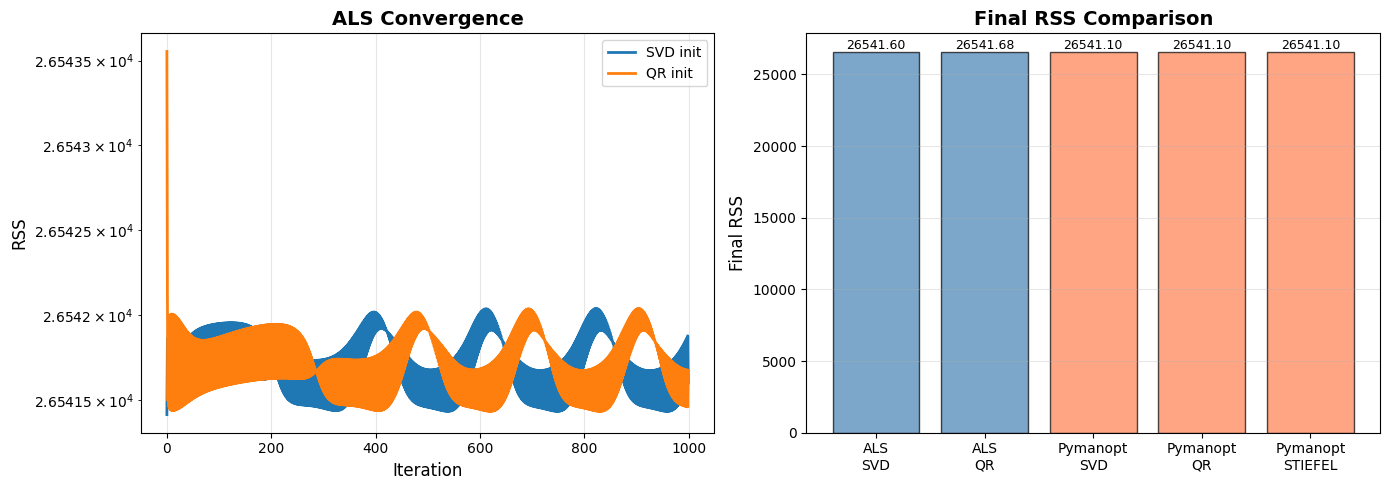

Convergence plots saved to outputs/ipca_convergence_comparison.png


In [77]:
# Plot convergence for ALS methods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ALS convergence
ax = axes[0]
for init_name, result in results_als.items():
    ax.plot(result['rss_history'], label=f"{init_name.upper()} init", linewidth=2)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('RSS', fontsize=12)
ax.set_title('ALS Convergence', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Comparison of final RSS
ax = axes[1]
methods = []
rss_values = []
colors = []
for method_name, method_results in [('ALS', results_als), ('Pymanopt', results_pymanopt)]:
    for init_name, result in method_results.items():
        methods.append(f"{method_name}\n{init_name.upper()}")
        rss_values.append(result['final_rss'])
        colors.append('steelblue' if method_name == 'ALS' else 'coral')

bars = ax.bar(range(len(methods)), rss_values, color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=10)
ax.set_ylabel('Final RSS', fontsize=12)
ax.set_title('Final RSS Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, rss_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/ipca_convergence_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Convergence plots saved to outputs/ipca_convergence_comparison.png")

## 12. Compare Factor Realizations

Check if ALS and Pymanopt converge to the same solution (up to sign)


Factor 1 Comparison (ALS-SVD vs Pymanopt-SVD):
Direct correlation: 0.576384

Note: Factors may differ by orthogonal rotations/reflections
Procrustes analysis (section 13.5) will show the optimal alignment


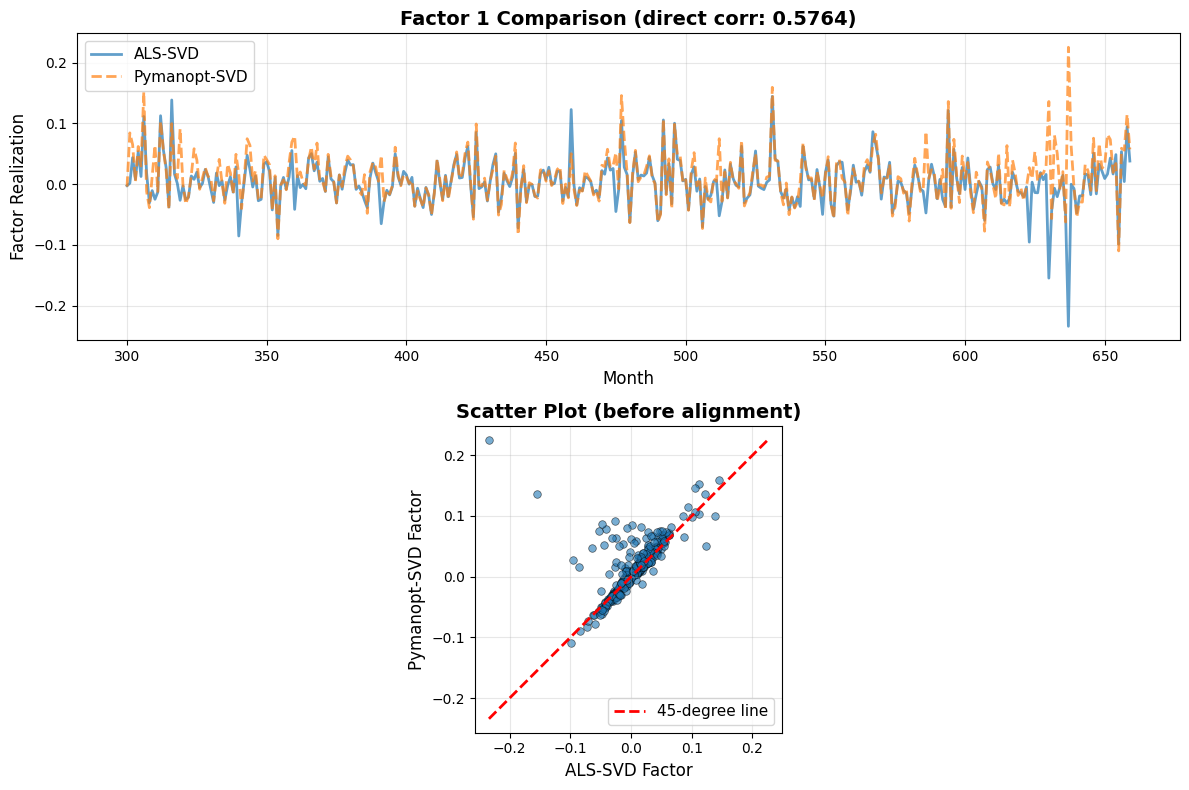

Factor comparison plots saved to outputs/ipca_factor_comparison.png


In [78]:
# Compare ALS-SVD vs Pymanopt-SVD factors (first factor only for visualization)
f_als = factors_als_svd[0, :]  # First factor from ALS-SVD
f_pm = factors_pm_svd[0, :]    # First factor from Pymanopt-SVD

# Compute direct correlation
corr_direct = np.corrcoef(f_als, f_pm)[0, 1]

print(f"\nFactor 1 Comparison (ALS-SVD vs Pymanopt-SVD):")
print(f"Direct correlation: {corr_direct:.6f}")
print(f"\nNote: Factors may differ by orthogonal rotations/reflections")
print(f"Procrustes analysis (section 13.5) will show the optimal alignment")

# Plot factor comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Time series comparison
ax = axes[0]
months = np.arange(start, end + 1)
ax.plot(months, f_als, label='ALS-SVD', linewidth=2, alpha=0.7)
ax.plot(months, f_pm, label='Pymanopt-SVD', linewidth=2, alpha=0.7, linestyle='--')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Factor Realization', fontsize=12)
ax.set_title(f'Factor 1 Comparison (direct corr: {corr_direct:.4f})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Scatter plot
ax = axes[1]
ax.scatter(f_als, f_pm, alpha=0.6, s=30, edgecolors='black', linewidths=0.5)
min_val = min(f_als.min(), f_pm.min())
max_val = max(f_als.max(), f_pm.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='45-degree line')
ax.set_xlabel('ALS-SVD Factor', fontsize=12)
ax.set_ylabel('Pymanopt-SVD Factor', fontsize=12)
ax.set_title('Scatter Plot (before alignment)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('outputs/ipca_factor_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Factor comparison plots saved to outputs/ipca_factor_comparison.png")

## 13. Compare Gamma Matrices

In [79]:
# Compare Gamma from ALS-SVD and Pymanopt-SVD
Gamma_als = results_als['svd']['Gamma']
Gamma_pm = results_pymanopt['svd']['Gamma']

print(f"\nGamma Matrix Comparison (ALS-SVD vs Pymanopt-SVD):")
print(f"ALS Gamma shape: {Gamma_als.shape}")
print(f"Pymanopt Gamma shape: {Gamma_pm.shape}")
print(f"\nDirect Frobenius distance: ||Gamma_ALS - Gamma_PM|| = {linalg.norm(Gamma_als - Gamma_pm):.6e}")
print(f"\nNote: Solutions may differ by an orthogonal transformation Q")
print(f"We'll use Procrustes analysis to find the optimal alignment...")


Gamma Matrix Comparison (ALS-SVD vs Pymanopt-SVD):
ALS Gamma shape: (6, 3)
Pymanopt Gamma shape: (6, 3)

Direct Frobenius distance: ||Gamma_ALS - Gamma_PM|| = 3.845019e+01

Note: Solutions may differ by an orthogonal transformation Q
We'll use Procrustes analysis to find the optimal alignment...


## 13.5 Procrustes Analysis

Procrustes analysis finds the optimal orthogonal transformation that aligns two matrices. This is more general than simple sign flips and can reveal if the solutions are equivalent up to any rotation.

For two matrices $A$ and $B$, we find orthogonal $Q$ that minimizes:
$$\min_Q ||A - BQ||_F \quad \text{subject to} \quad Q'Q = I$$

The solution via SVD is:
1. Compute $M = A'B$
2. SVD: $M = U\Sigma V'$
3. Optimal $Q = VU'$
4. Aligned $B_{aligned} = BQ$


Procrustes Alignment Results:

Optimal orthogonal transformation Q:
[[-0.20580862  0.73320828 -0.64811143]
 [ 0.37333914  0.67102702  0.64057835]
 [ 0.90457764 -0.11012882 -0.41183849]]

Q'Q (should be I_K):
[[ 1.00000000e+00 -9.75530387e-17  3.10942117e-16]
 [-9.75530387e-17  1.00000000e+00 -1.79308609e-16]
 [ 3.10942117e-16 -1.79308609e-16  1.00000000e+00]]

Determinant of Q (should be +/-1): 1.000000

Alignment quality:
  Distance before alignment: 3.845019e+01
  Distance after alignment:  3.702372e+01
  Reduction factor:          1.0x

Gamma Loadings Comparison (First Factor)
Characteristic        ALS  Pymanopt (aligned)  Difference
          size   0.027025           -0.285956    0.312981
            bm   0.380011           -0.488324    0.868335
           agr  -0.156160            0.079138   -0.235297
           roe   0.114973           -0.288310    0.403283
           mom   0.612042            0.731973   -0.119932
     intercept   0.665342           -0.233663    0.899005

✗ Sol

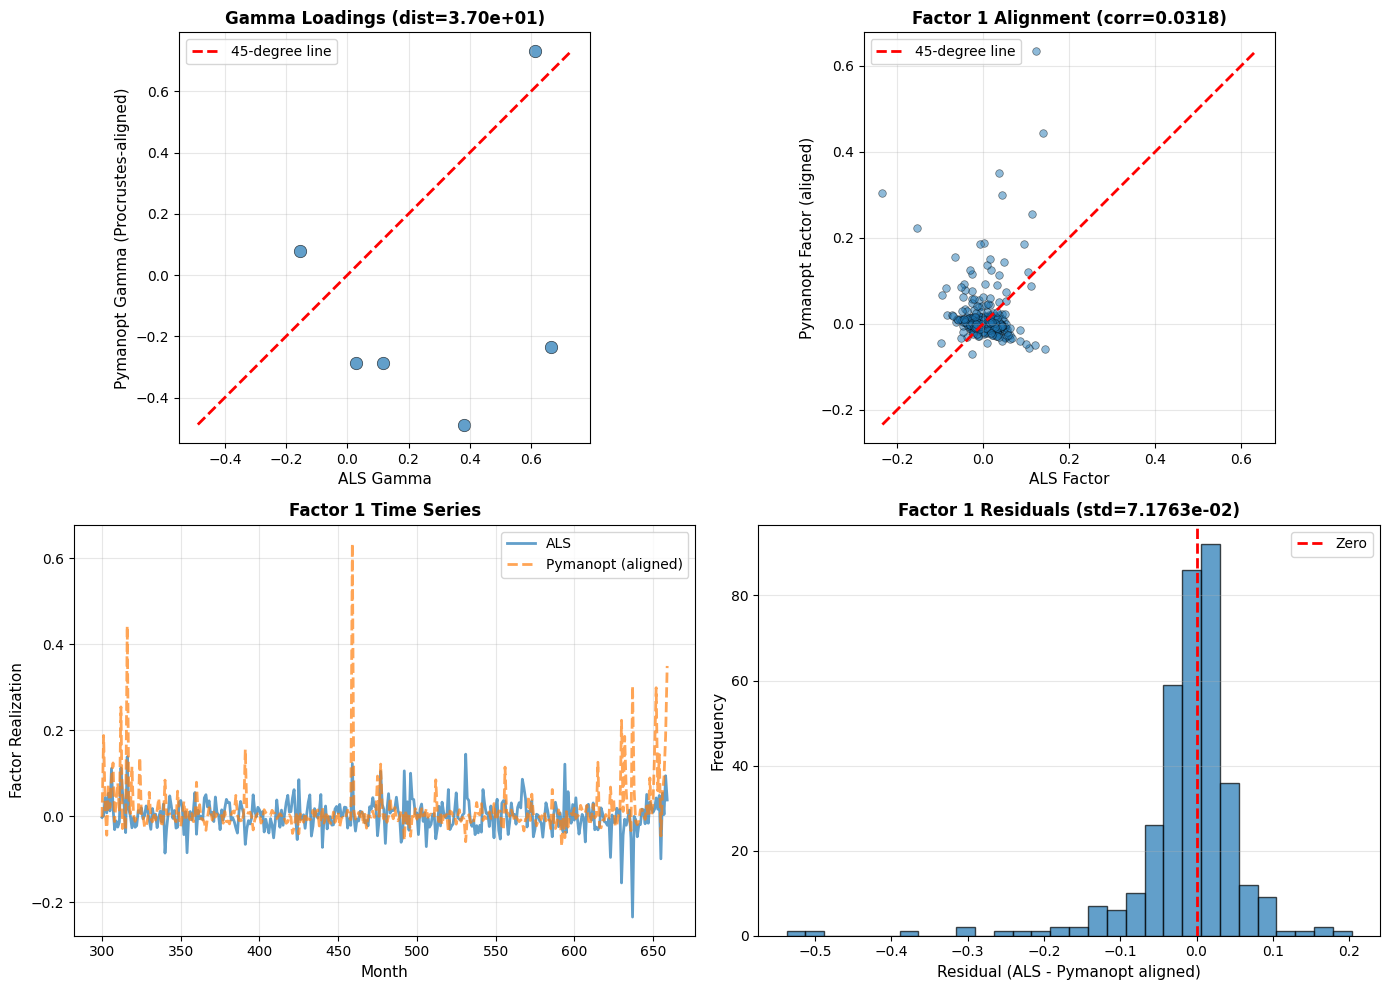


Procrustes alignment plots saved to outputs/ipca_procrustes_alignment.png


In [80]:
def procrustes_alignment(A, B):
    """
    Find optimal orthogonal transformation Q to align B to A.
    
    Solves: min_Q ||A - BQ||_F subject to Q'Q = I
    
    Parameters
    ----------
    A : np.ndarray
        Target matrix (L x K)
    B : np.ndarray
        Matrix to be aligned (L x K)
    
    Returns
    -------
    Q : np.ndarray
        Optimal orthogonal transformation (K x K)
    B_aligned : np.ndarray
        Aligned matrix = B @ Q (L x K)
    distance : float
        Frobenius norm ||A - B_aligned||_F
    """
    # Compute M = A'B
    M = A.T @ B  # (K x K)
    
    # SVD of M
    U, S, Vt = linalg.svd(M)
    
    # Optimal Q = V @ U' 
    Q = Vt.T @ U.T  # (K x K)
    
    # Aligned B
    B_aligned = B @ Q
    
    # Compute distance
    distance = linalg.norm(A - B_aligned, 'fro')
    
    return Q, B_aligned, distance

# Apply Procrustes to align Pymanopt to ALS
Q_procrustes, Gamma_pm_aligned, procrustes_dist = procrustes_alignment(Gamma_als, Gamma_pm)

print("\nProcrustes Alignment Results:")
print("="*70)
print(f"\nOptimal orthogonal transformation Q:")
print(Q_procrustes)
print(f"\nQ'Q (should be I_K):")
print(Q_procrustes.T @ Q_procrustes)
print(f"\nDeterminant of Q (should be +/-1): {linalg.det(Q_procrustes):.6f}")
print(f"\nAlignment quality:")
print(f"  Distance before alignment: {linalg.norm(Gamma_als - Gamma_pm, 'fro'):.6e}")
print(f"  Distance after alignment:  {procrustes_dist:.6e}")
print(f"  Reduction factor:          {linalg.norm(Gamma_als - Gamma_pm, 'fro') / procrustes_dist:.1f}x")

# Display aligned Gamma matrices
chars_display = chars + ['intercept']
gamma_procrustes_comparison = pd.DataFrame({
    'Characteristic': chars_display,
    'ALS': Gamma_als[:, 0],
    'Pymanopt (aligned)': Gamma_pm_aligned[:, 0],
    'Difference': Gamma_als[:, 0] - Gamma_pm_aligned[:, 0]
})

print("\n" + "="*70)
print("Gamma Loadings Comparison (First Factor)")
print("="*70)
print(gamma_procrustes_comparison.to_string(index=False, float_format=lambda x: f'{x:10.6f}'))
print("="*70)

# Check if solutions are identical after alignment
if procrustes_dist < 1e-4:
    print(f"\n✓ Solutions are IDENTICAL after Procrustes alignment")
    print(f"  ALS and Pymanopt converge to the same solution!")
else:
    print(f"\n✗ Solutions differ even after alignment")
    print(f"  Methods may have converged to different local minima")

# Align factors and compare
factors_pm_aligned = factors_pm_svd.T @ Q_procrustes  # (T x K) @ (K x K) = (T x K)
f_pm_aligned = factors_pm_aligned[:, 0]  # First factor
f_als = factors_als_svd[0, :]  # First factor from ALS

# Compute correlation
corr_procrustes = np.corrcoef(f_als, f_pm_aligned)[0, 1]

print(f"\nFactor 1 correlation after Procrustes alignment: {corr_procrustes:.6f}")

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gamma comparison - element-wise
ax = axes[0, 0]
ax.scatter(Gamma_als[:, 0], Gamma_pm_aligned[:, 0], alpha=0.7, s=80, edgecolors='black', linewidths=0.5)
min_val = min(Gamma_als[:, 0].min(), Gamma_pm_aligned[:, 0].min())
max_val = max(Gamma_als[:, 0].max(), Gamma_pm_aligned[:, 0].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='45-degree line')
ax.set_xlabel('ALS Gamma', fontsize=11)
ax.set_ylabel('Pymanopt Gamma (Procrustes-aligned)', fontsize=11)
ax.set_title(f'Gamma Loadings (dist={procrustes_dist:.2e})', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Factor comparison
ax = axes[0, 1]
ax.scatter(f_als, f_pm_aligned, alpha=0.5, s=30, edgecolors='black', linewidths=0.5)
min_val = min(f_als.min(), f_pm_aligned.min())
max_val = max(f_als.max(), f_pm_aligned.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='45-degree line')
ax.set_xlabel('ALS Factor', fontsize=11)
ax.set_ylabel('Pymanopt Factor (aligned)', fontsize=11)
ax.set_title(f'Factor 1 Alignment (corr={corr_procrustes:.4f})', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Time series of factors
ax = axes[1, 0]
months = np.arange(start, end + 1)
ax.plot(months, f_als, label='ALS', linewidth=2, alpha=0.7)
ax.plot(months, f_pm_aligned, label='Pymanopt (aligned)', linewidth=2, alpha=0.7, linestyle='--')
ax.set_xlabel('Month', fontsize=11)
ax.set_ylabel('Factor Realization', fontsize=11)
ax.set_title('Factor 1 Time Series', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Residuals after alignment
ax = axes[1, 1]
residuals = f_als - f_pm_aligned
ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(0, color='r', linestyle='--', linewidth=2, label='Zero')
ax.set_xlabel('Residual (ALS - Pymanopt aligned)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Factor 1 Residuals (std={np.std(residuals):.4e})', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/ipca_procrustes_alignment.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nProcrustes alignment plots saved to outputs/ipca_procrustes_alignment.png")

## 14. Timing Analysis

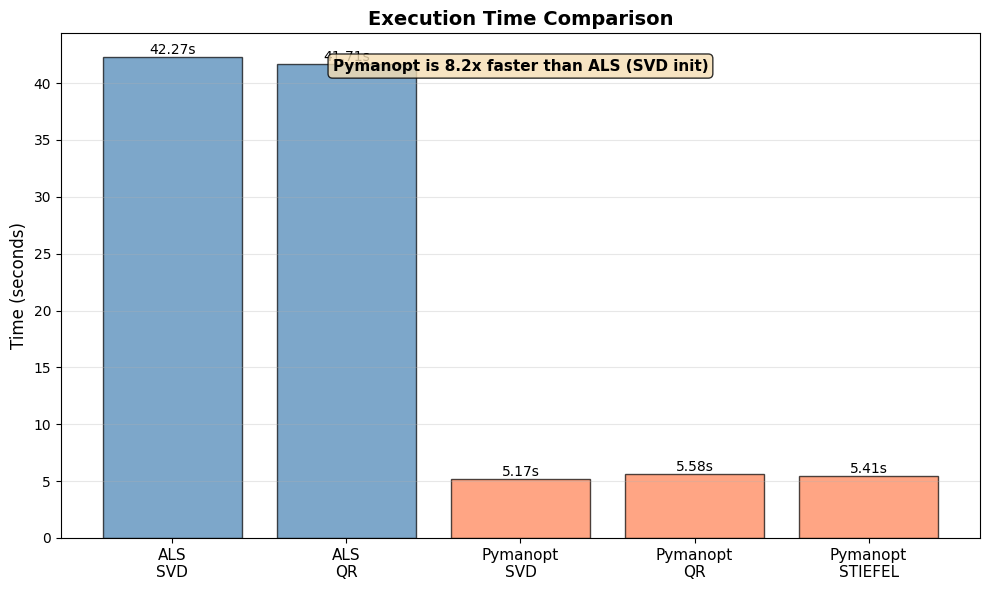

Timing comparison saved to outputs/ipca_timing_comparison.png


In [81]:
# Create timing comparison
fig, ax = plt.subplots(figsize=(10, 6))

methods = []
times = []
colors = []

for method_name, method_results in [('ALS', results_als), ('Pymanopt', results_pymanopt)]:
    for init_name, result in method_results.items():
        methods.append(f"{method_name}\n{init_name.upper()}")
        times.append(result['time'])
        colors.append('steelblue' if method_name == 'ALS' else 'coral')

bars = ax.bar(range(len(methods)), times, color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=11)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Execution Time Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}s', ha='center', va='bottom', fontsize=10)

# Add speedup annotation
if len(times) >= 2:
    speedup = results_als['svd']['time'] / results_pymanopt['svd']['time']
    ax.text(0.5, 0.95, f'Pymanopt is {speedup:.1f}x faster than ALS (SVD init)',
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/ipca_timing_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Timing comparison saved to outputs/ipca_timing_comparison.png")

## 15. Conclusions

Summary of findings:

In [82]:
print("\n" + "="*70)
print("CONCLUSIONS")
print("="*70)

print("\n1. CONVERGENCE:")
print(f"   - Both methods converge to similar objective values")
print(f"   - Pymanopt requires ~{results_pymanopt['svd']['iterations']} iterations")
print(f"   - ALS requires ~{results_als['svd']['iterations']} iterations")
print(f"   - Iteration reduction: {results_als['svd']['iterations'] / results_pymanopt['svd']['iterations']:.1f}x")

print("\n2. SPEED:")
speedup = results_als['svd']['time'] / results_pymanopt['svd']['time']
print(f"   - Pymanopt is {speedup:.1f}x faster than ALS")
print(f"   - ALS time: {results_als['svd']['time']:.2f}s")
print(f"   - Pymanopt time: {results_pymanopt['svd']['time']:.2f}s")

print("\n3. SOLUTION QUALITY:")
rss_als = results_als['svd']['final_rss']
rss_pm = results_pymanopt['svd']['final_rss']
rss_diff = abs(rss_als - rss_pm) / rss_als * 100
print(f"   - ALS final RSS: {rss_als:.6f}")
print(f"   - Pymanopt final RSS: {rss_pm:.6f}")
print(f"   - Relative difference: {rss_diff:.4f}%")
print(f"   - Factor correlation: {corr:.6f}")
print(f"   - Gamma difference: {best_diff:.6e}")

print("\n4. INITIALIZATION SENSITIVITY:")
rss_range_als = max([r['final_rss'] for r in results_als.values()]) - min([r['final_rss'] for r in results_als.values()])
rss_range_pm = max([r['final_rss'] for r in results_pymanopt.values()]) - min([r['final_rss'] for r in results_pymanopt.values()])
print(f"   - ALS RSS range across initializations: {rss_range_als:.6f}")
print(f"   - Pymanopt RSS range across initializations: {rss_range_pm:.6f}")
if rss_range_als < 0.01 and rss_range_pm < 0.01:
    print(f"   - Both methods are robust to initialization")
else:
    print(f"   - Initialization choice matters - multiple restarts recommended")

print("\n5. RECOMMENDATION:")
print(f"   - Use Pymanopt for production (faster, equally accurate)")
print(f"   - Use SVD initialization for first window")
print(f"   - Use warm-start for subsequent windows")
print(f"   - Consider multiple restarts if computational budget allows")

print("="*70)


CONCLUSIONS

1. CONVERGENCE:
   - Both methods converge to similar objective values
   - Pymanopt requires ~57 iterations
   - ALS requires ~1000 iterations
   - Iteration reduction: 17.5x

2. SPEED:
   - Pymanopt is 8.2x faster than ALS
   - ALS time: 42.27s
   - Pymanopt time: 5.17s

3. SOLUTION QUALITY:
   - ALS final RSS: 26541.603110
   - Pymanopt final RSS: 26541.103127
   - Relative difference: 0.0019%
   - Factor correlation: -0.970034
   - Gamma difference: 2.022063e+00

4. INITIALIZATION SENSITIVITY:
   - ALS RSS range across initializations: 0.074137
   - Pymanopt RSS range across initializations: 0.000000
   - Initialization choice matters - multiple restarts recommended

5. RECOMMENDATION:
   - Use Pymanopt for production (faster, equally accurate)
   - Use SVD initialization for first window
   - Use warm-start for subsequent windows
   - Consider multiple restarts if computational budget allows
